### Here is an example notebook on how to classify a physics signal and background using a dense neural network in keras

##### Our signal here is exotic higgs  and our The background process, which mimics W∓W±b¯b without the Higgs boson intermediate state, is the production of a pair of top quarks, each of which decay to W b, also giving W∓W±b¯b.

The signal process is the fusion of two gluons into a
heavy electrically-neutral Higgs boson (gg → H0
), which
decays to a heavy electrically-charged Higgs bosons (H±)
and a W boson. The H± boson subsequently decays to a
second W boson and the light Higgs boson, h0 which subsequently decays to bottom quarks 

The dataset we will be using will be a skimmed sample from the public Higgs dataset made available by Daniel Whiteson. More details of this dataset could be found below

https://arxiv.org/pdf/1402.4735.pdf


http://archive.ics.uci.edu/ml/datasets/HIGGS


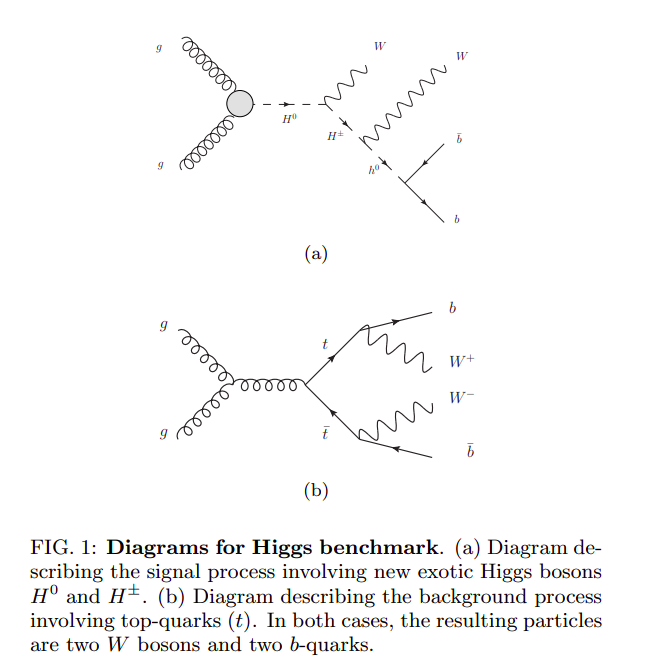

So let us start by importing some packages

In [1]:
%matplotlib inline

import random

import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

Our first task will be to load our input signal and background output files(which are root ntuples)into a format that could that could be readable(pandas dataframe or numpy array) by our machine learning packages. For this we will be using uproot3. uproot is a  package/tool  to read and write root files into numpy and dataframe formats,It has many other great functionalities.  see https://masonproffitt.github.io/uproot-tutorial/aio.html for a tutorial on how to get started with uproot. 

In [2]:
import uproot3 as uproot

In [3]:
#!curl https://cernbox.cern.ch/index.php/s/zH3RI8xCD7Z75ar/download -o  Data-MLtutorial.tar
#!tar -xvf Data-MLtutorial.tar

In [4]:

signal = uproot.open("HIGGSsignal.root")

Now lets see whats inside this file

In [5]:
signal.keys()

[b'tree;1']

We can see that there is one key: “tree”. This doesn’t tell us what kind of object it refers to, though. ROOT files can contain many different types of objects, including subdirectories. The following function provides a way to inspect the types of each item

In [6]:
signal.classnames()

[(b'tree;1', 'TTree')]

We can see that "tree" is a root TTree object. lets load it and see whats inside

In [7]:
signal['tree'].keys()

[b'y',
 b'lepton_pT',
 b'lepton_eta',
 b'lepton_phi',
 b'missing_energy_magnitude',
 b'missing_energy_phi',
 b'jet_1_pt',
 b'jet_1_eta',
 b'jet_1_phi',
 b'jet_1_b_tag',
 b'jet_2_pt',
 b'jet_2_eta',
 b'jet_2_phi',
 b'jet_2_b_tag',
 b'jet_3_pt',
 b'jet_3_eta',
 b'jet_3_phi',
 b'jet_3_b_tag',
 b'jet_4_pt',
 b'jet_4_eta',
 b'jet_4_phi',
 b'jet_4_b_tag',
 b'm_jj',
 b'm_jjj',
 b'm_lv',
 b'm_jlv',
 b'm_bb',
 b'm_wbb',
 b'm_wwbb']

We can see that there are 28 features and a label called y. The first 21 features are low level features and the next 7 are high level features like the invariant masses constructed from these low level features . Now that we are familiar with how to access these branches, we can now directly load them in one step 


In [8]:

signal = uproot.open("HIGGSsignal.root")['tree']




In [9]:
signal.keys()

[b'y',
 b'lepton_pT',
 b'lepton_eta',
 b'lepton_phi',
 b'missing_energy_magnitude',
 b'missing_energy_phi',
 b'jet_1_pt',
 b'jet_1_eta',
 b'jet_1_phi',
 b'jet_1_b_tag',
 b'jet_2_pt',
 b'jet_2_eta',
 b'jet_2_phi',
 b'jet_2_b_tag',
 b'jet_3_pt',
 b'jet_3_eta',
 b'jet_3_phi',
 b'jet_3_b_tag',
 b'jet_4_pt',
 b'jet_4_eta',
 b'jet_4_phi',
 b'jet_4_b_tag',
 b'm_jj',
 b'm_jjj',
 b'm_lv',
 b'm_jlv',
 b'm_bb',
 b'm_wbb',
 b'm_wwbb']

Now let us convert our signal into a pandas dataframe

In [10]:
#df_signal = signal.pandas.df(['lep*','m*','je*'])
df_signal = signal.pandas.df(['m_*'])

Lets see what this looks like

In [11]:

df_signal

,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
entry,,,,,,,
0,1.353760,0.979563,0.978076,0.920005,0.721657,0.988751,0.876678
1,0.302220,0.833048,0.985700,0.978098,0.779732,0.992356,0.798343
2,0.909753,1.108330,0.985692,0.951331,0.803252,0.865924,0.780118
3,0.755856,1.361057,0.986610,0.838085,1.133295,0.872245,0.808487
4,0.869418,1.222083,1.000627,0.545045,0.698653,0.977314,0.828786
...,...,...,...,...,...,...,...
529668,0.948664,1.029377,1.052701,0.773623,0.318335,0.895034,0.838218
529669,0.905958,0.844373,0.985637,1.013631,0.937575,0.974468,0.829529
529670,0.607600,0.733236,1.187110,0.943022,0.315795,0.615857,0.772179


Now we have converted our root tree object("tree") into a beautiful pandas dataframe with all the variables and event number.

Lets get a summary of the variables


In [12]:
df_signal.describe()

,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
count,529673.000000,529673.000000,529673.000000,529673.000000,529673.000000,529673.000000,529673.000000
mean,1.042085,1.033991,1.052146,0.998265,0.898367,1.010929,0.923550
std,0.689983,0.398403,0.164187,0.361240,0.385492,0.332632,0.283286
min,0.102745,0.265392,0.216722,0.231570,0.048125,0.303350,0.350939
25%,0.793733,0.834640,0.985767,0.750714,0.702499,0.836205,0.767539
50%,0.898161,0.964710,0.989793,0.926408,0.854773,0.939130,0.845703
75%,1.029020,1.111174,1.023486,1.160156,0.998759,1.085242,0.991096
max,31.076191,15.637859,5.021787,8.140121,8.543781,8.779915,6.259156


Now lets do the same for background

In [13]:
background = uproot.open("HIGGSbackground.root")['tree']

In [14]:
#df_background = background.pandas.df(['lep*','m_*','je*'])
df_background = background.pandas.df(['m_*'])

In [15]:
df_background.describe()

,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
count,470327.000000,470327.000000,470327.000000,470327.000000,470327.000000,470327.000000,470327.000000
mean,1.025513,1.014676,1.048710,1.022925,1.057518,1.058604,1.000776
std,0.651225,0.357472,0.164547,0.434946,0.637038,0.396879,0.339150
min,0.101168,0.234753,0.092202,0.157473,0.053756,0.328602,0.375679
25%,0.787526,0.856122,0.985729,0.783803,0.630078,0.797404,0.775218
50%,0.891272,0.940045,0.989747,0.908422,0.927548,0.965473,0.918701
75%,1.019377,1.048377,1.016987,1.117666,1.326014,1.207368,1.130223
max,21.828766,11.413766,5.921233,10.794087,13.735691,8.432360,6.015647


We can see that there are about 530k signal and 470k background events. The number of signal and background events are similar which is ideal for training

Now we need to assign labels to these signal(label 1) and background(label 0). So now have our signal and background events in seperate dataframes(df_signal and df_background). Lets assign a target value 1 for signal and 0 for background and combine them to a single dataframe.

In [16]:
df_signal=df_signal.assign(y=1)
df_background =df_background.assign(y=0)

In [17]:
df_list = [df_signal,df_background]

In [18]:
df = pd.concat(df_list)

In [19]:
df.describe()

,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb,y
count,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000,1000000.000000
mean,1.034291,1.024907,1.050530,1.009863,0.973220,1.033352,0.959872,0.529673
std,0.672083,0.379824,0.164366,0.397802,0.525251,0.365039,0.313194,0.499119
min,0.101168,0.234753,0.092202,0.157473,0.048125,0.303350,0.350939,0.000000
25%,0.790729,0.846332,0.985750,0.767338,0.673858,0.819379,0.770333,0.000000
50%,0.894967,0.950568,0.989771,0.916455,0.873490,0.947443,0.871788,1.000000
75%,1.024375,1.083443,1.020216,1.142236,1.139482,1.140750,1.059245,1.000000
max,31.076191,15.637859,5.921233,10.794087,13.735691,8.779915,6.259156,1.000000


So now we have combined our signal and background into a sigle dataframe using pd.concat. Lets plot these variables using matplotlib.

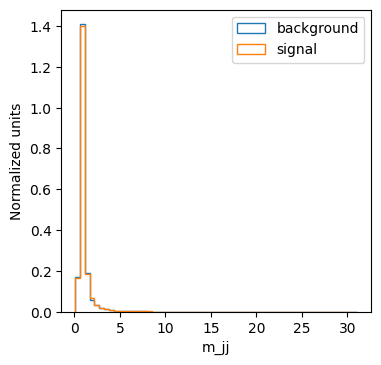

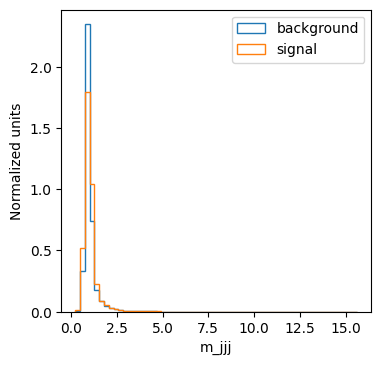

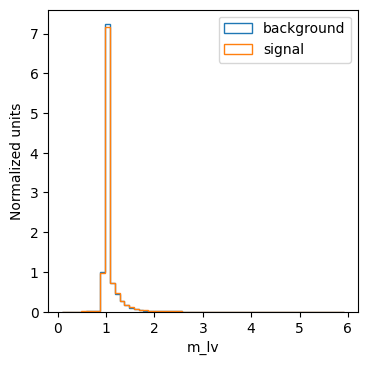

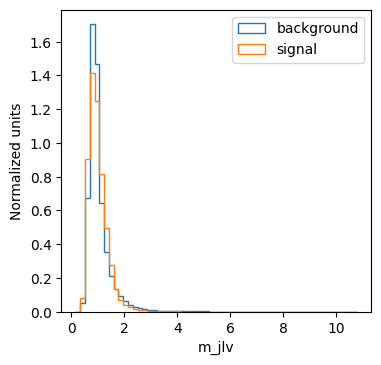

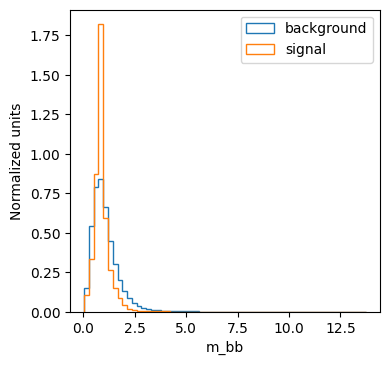

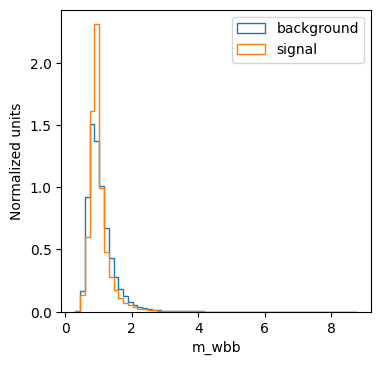

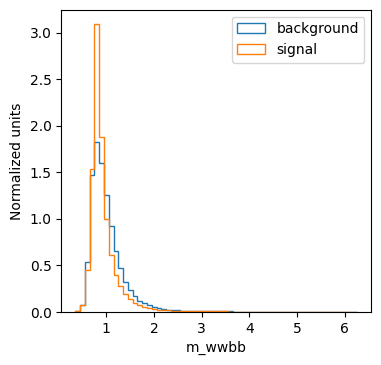

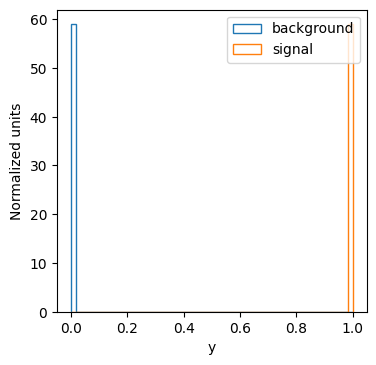

In [20]:
# iterate through the columns
for key in df.keys():
    # plotting settings
    #matplotlib.rcParams.update({'font.size': 16})
    fig = plt.figure(figsize=(4, 4), dpi=100)
    bins = np.linspace(min(df[key]), max(df[key]), 60)
    # plot!
    plt.hist(df[df.y<0.5][key], bins=bins, histtype='step',label='background',density=1)
    plt.hist(df[df.y>=0.5][key], bins=bins, histtype='step',label='signal',density=1)
    
    # decorate
    plt.xlabel(key)
    plt.ylabel('Normalized units')
    plt.legend()
    plt.plot()
    #plt.savefig("{}.png".format(key), bbox_inches="tight")

In [21]:
dataset = df.values

In [22]:
X = dataset[:,0:7] # Load only high level features
y = dataset[:,7]

In [23]:
y

array([1., 1., 1., ..., 0., 0., 0.])

In [24]:
X


array([[1.35376   , 0.97956312, 0.97807616, ..., 0.72165745, 0.98875093,
        0.87667835],
       [0.3022199 , 0.83304816, 0.98569965, ..., 0.77973217, 0.99235576,
        0.79834259],
       [0.90975326, 1.10833049, 0.9856922 , ..., 0.8032515 , 0.86592442,
        0.78011757],
       ...,
       [1.03329051, 0.87824315, 1.20724857, ..., 1.97767091, 1.18653727,
        1.02507317],
       [1.2408582 , 1.85025418, 0.98409927, ..., 0.51411855, 1.74225903,
        2.7513907 ],
       [0.33329549, 0.75872505, 0.98809707, ..., 0.27138123, 0.72327971,
        0.60105246]])

In [25]:
y

array([1., 1., 1., ..., 0., 0., 0.])

Now lets split our Inputs and labels randomly training and testing data

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
X_train,X_test, y_train,y_test = train_test_split(X, y,
                                                  test_size=0.20, random_state=45)

In [28]:
len(X_train)

800000

##### We have now completed our first step. The next step is to construct and train our neural network model.

Let's first import keras,tensorflow etc

In [29]:
import numpy as np
np.random.seed(1234)
import os
#os.environ["KERAS_BACKEND"] = "tensorflow"
import subprocess
import pickle
#from tensorflow import keras

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

from sklearn.preprocessing import StandardScaler

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Activation
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TerminateOnNaN


In [31]:

input_shape = X_train.shape[1]
dropoutRate = 0.1

we will now train two seperate models , one shallow and one dense and compare the performance of the two

In [32]:
####
inputArray = Input(shape=(input_shape,))
#
x = Dense(100, activation='relu')(inputArray)
#
output = Dense(1, activation='sigmoid')(x)
####
model_shallow = Model(inputs=inputArray, outputs=output)

2022-08-26 11:37:04.508156: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [33]:
model_shallow.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense (Dense)               (None, 100)               800       
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 901
Trainable params: 901
Non-trainable params: 0
_________________________________________________________________


In [34]:
model_shallow.compile( loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [35]:
####
inputArray = Input(shape=(input_shape,))
#
x = Dense(100, activation='relu')(inputArray)
x = Dropout(dropoutRate)(x)
#
x = Dense(100)(x)
x = Activation('relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(64, activation='relu')(x)
x = Dropout(dropoutRate)(x)
#
x = Dense(32, activation='relu')(x)
#
output = Dense(1, activation='sigmoid')(x)
####
model_deep = Model(inputs=inputArray, outputs=output)

In [36]:
model_deep.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 7)]               0         
                                                                 
 dense_2 (Dense)             (None, 100)               800       
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_3 (Dense)             (None, 100)               10100     
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout_1 (Dropout)         (None, 100)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                6464

In [37]:

model_deep.compile( loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [38]:
preprocessing_input = StandardScaler()

In [39]:
preprocessing_input = StandardScaler()
preprocessing_input.fit(X_train)
pickle.dump(preprocessing_input, open("HIGGS_preprocessing.pickle", "wb"))


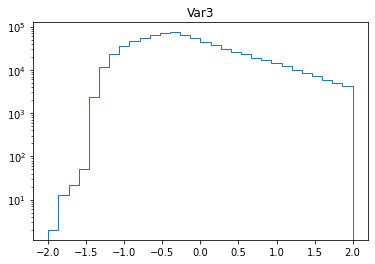

In [40]:
preprocessed_input  = preprocessing_input.transform(X_train)
plt.hist(preprocessed_input[:,3],bins=30,range=(-2,2),histtype='step')
plt.yscale('log')
plt.title('Var3')
plt.show()

In [41]:
class_weights = {0:len(y)/(y==0).sum(),
                 1:len(y)/(y==1).sum()
                 }

In [42]:
class_weights

{0: 2.1261802958367264, 1: 1.8879572868543422}

In [43]:
from keras import callbacks

In [44]:
Xt_train = preprocessing_input.transform(X_train)
Xt_test =preprocessing_input.transform(X_test)

In [45]:
early_stopper = callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="auto")
model_check_point = callbacks.ModelCheckpoint("model_shallow.h5", monitor = 'val_loss', verbose=True, 
                                              save_best_only=True, mode='min')

    
print("Train now the shallow model ")
    
history_s = model_shallow.fit(
                Xt_train,
                y_train,
                batch_size=1024,
                epochs=30,
                validation_split=0.2,
                callbacks=[early_stopper, model_check_point])

Train now the shallow model 
Epoch 1/30
607/625 [============================>.] - ETA: 0s - loss: 0.6225 - accuracy: 0.6510
Epoch 1: val_loss improved from inf to 0.59591, saving model to model_shallow.h5
625/625 [==============================] - 2s 3ms/step - loss: 0.6218 - accuracy: 0.6519 - val_loss: 0.5959 - val_accuracy: 0.6773
Epoch 2/30
610/625 [============================>.] - ETA: 0s - loss: 0.5891 - accuracy: 0.6859
Epoch 2: val_loss improved from 0.59591 to 0.58091, saving model to model_shallow.h5
625/625 [==============================] - 2s 3ms/step - loss: 0.5889 - accuracy: 0.6860 - val_loss: 0.5809 - val_accuracy: 0.6924
Epoch 3/30
613/625 [============================>.] - ETA: 0s - loss: 0.5788 - accuracy: 0.6927
Epoch 3: val_loss improved from 0.58091 to 0.57420, saving model to model_shallow.h5
625/625 [==============================] - 2s 3ms/step - loss: 0.5787 - accuracy: 0.6928 - val_loss: 0.5742 - val_accuracy: 0.6960
Epoch 4/30
619/625 [===================

624/625 [============================>.] - ETA: 0s - loss: 0.5570 - accuracy: 0.7056
Epoch 28: val_loss improved from 0.55542 to 0.55529, saving model to model_shallow.h5
625/625 [==============================] - 2s 3ms/step - loss: 0.5571 - accuracy: 0.7055 - val_loss: 0.5553 - val_accuracy: 0.7070
Epoch 29/30
610/625 [============================>.] - ETA: 0s - loss: 0.5568 - accuracy: 0.7062
Epoch 29: val_loss did not improve from 0.55529
625/625 [==============================] - 2s 2ms/step - loss: 0.5567 - accuracy: 0.7062 - val_loss: 0.5554 - val_accuracy: 0.7067
Epoch 30/30
608/625 [============================>.] - ETA: 0s - loss: 0.5568 - accuracy: 0.7061
Epoch 30: val_loss did not improve from 0.55529
625/625 [==============================] - 2s 2ms/step - loss: 0.5567 - accuracy: 0.7061 - val_loss: 0.5555 - val_accuracy: 0.7060


In [46]:
print("Train now the deep model ")


early_stopper = callbacks.EarlyStopping(monitor="val_loss", patience=5, mode="min", verbose=True)
model_check_point = callbacks.ModelCheckpoint("model_deep.h5", monitor = 'val_loss', verbose=True, 
                                              save_best_only=True, mode='min')


history_d = model_deep.fit(
                Xt_train,
                y_train,
                batch_size=1024,
                epochs=30,
                validation_split=0.2,
                callbacks=[early_stopper, model_check_point])

Train now the deep model 
Epoch 1/30
624/625 [============================>.] - ETA: 0s - loss: 0.5862 - accuracy: 0.6828
Epoch 1: val_loss improved from inf to 0.55949, saving model to model_deep.h5
625/625 [==============================] - 4s 6ms/step - loss: 0.5862 - accuracy: 0.6828 - val_loss: 0.5595 - val_accuracy: 0.7025
Epoch 2/30
619/625 [============================>.] - ETA: 0s - loss: 0.5654 - accuracy: 0.6981
Epoch 2: val_loss improved from 0.55949 to 0.55416, saving model to model_deep.h5
625/625 [==============================] - 4s 6ms/step - loss: 0.5655 - accuracy: 0.6982 - val_loss: 0.5542 - val_accuracy: 0.7067
Epoch 3/30
621/625 [============================>.] - ETA: 0s - loss: 0.5612 - accuracy: 0.7006
Epoch 3: val_loss improved from 0.55416 to 0.55144, saving model to model_deep.h5
625/625 [==============================] - 4s 6ms/step - loss: 0.5612 - accuracy: 0.7007 - val_loss: 0.5514 - val_accuracy: 0.7091
Epoch 4/30
619/625 [============================>.]

Epoch 29/30
620/625 [============================>.] - ETA: 0s - loss: 0.5482 - accuracy: 0.7113
Epoch 29: val_loss did not improve from 0.54292
625/625 [==============================] - 4s 6ms/step - loss: 0.5481 - accuracy: 0.7114 - val_loss: 0.5433 - val_accuracy: 0.7151
Epoch 30/30
622/625 [============================>.] - ETA: 0s - loss: 0.5479 - accuracy: 0.7113
Epoch 30: val_loss did not improve from 0.54292
625/625 [==============================] - 4s 6ms/step - loss: 0.5478 - accuracy: 0.7113 - val_loss: 0.5436 - val_accuracy: 0.7153
Epoch 30: early stopping


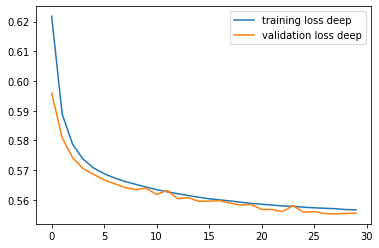

In [47]:
plt.plot(history_s.history["loss"], label="training loss shallow")
plt.plot(history_s.history["val_loss"], label="validation loss shallow")
plt.legend()
plt.show()

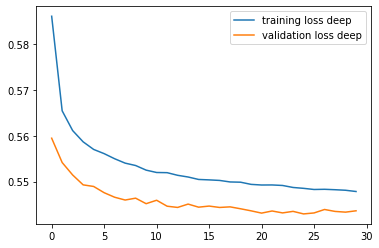

In [48]:
plt.plot(history_d.history["loss"], label="training loss deep")
plt.plot(history_d.history["val_loss"], label="validation loss deep")
plt.legend()
plt.show()

In [59]:
from keras.models import load_model

In [60]:
model_shallow = load_model("model_shallow.h5")
model_deep = load_model("model_deep.h5")
preprocessing_input = pickle.load(open("HIGGS_preprocessing.pickle", "rb"))

In [61]:
print('testing models using',X_test.shape[0],'events')

ntest_evts = X_test.shape[0]

testing models using 200000 events


In [62]:
Xt_test =preprocessing_input.transform(X_test)
Xt_train =preprocessing_input.transform(X_train)  

In [63]:
print('testing models using',X_test.shape[0],'events')

ntest_evts = X_test.shape[0]
#in case we want to use a smaller set of test data 
#num_events = 200000
predictions_shallow = model_shallow.predict(
        Xt_test)
predictions_deep = model_deep.predict(
        Xt_test)

testing models using 200000 events


In [64]:
predictions_shallow

array([[0.1893324 ],
       [0.28291184],
       [0.7105172 ],
       ...,
       [0.49451515],
       [0.5872761 ],
       [0.32598776]], dtype=float32)

In [65]:
predictions_deep

array([[0.18292901],
       [0.31510687],
       [0.8451056 ],
       ...,
       [0.40510762],
       [0.5395786 ],
       [0.33694574]], dtype=float32)

In [66]:
from sklearn.metrics import roc_auc_score,roc_curve,auc

In [70]:
fpr_shallow, tpr_shallow, _ = roc_curve(y_test, predictions_shallow)
fpr_deep, tpr_deep, _ = roc_curve(y_test, predictions_deep)


In [72]:
auc_shallow = auc(fpr_shallow, tpr_shallow)
auc_deep = auc(fpr_deep, tpr_deep)

print("AUC  deep model   = ",auc_deep)

print("AUC  shallow model   = ",auc_shallow)

AUC  deep model   =  0.7917111805534677
AUC  shallow model   =  0.7813629854948495


(0.0, 1.0)

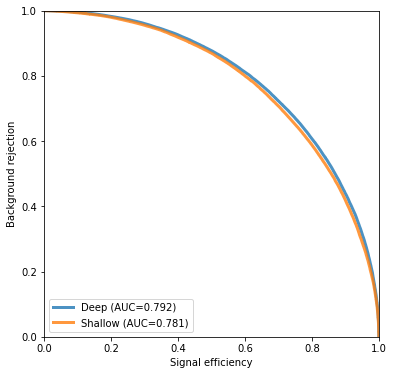

In [73]:
plt.figure(figsize=(6,6))
plt.plot(tpr_deep, 1.0-fpr_deep, lw=3, alpha=0.8,
        label="Deep (AUC={:.3f})".format(auc_deep))
plt.plot(tpr_shallow, 1.0-fpr_shallow, lw=3, alpha=0.8,
        label="Shallow (AUC={:.3f})".format(auc_shallow))
plt.xlabel("Signal efficiency")
plt.ylabel("Background rejection")
plt.legend(loc=3)
plt.xlim((0.0, 1.0))
plt.ylim((0.0, 1.0))
#plt.savefig("HIGGS_roc.png", bbox_inches="tight")

In [78]:

predictions_shallow_tr = model_shallow.predict((Xt_train))
predictions_deeptr = model_deep.predict((Xt_train))

In [79]:
fpr_shallow_tr, tpr_shallow_tr, _ = roc_curve(y_train, predictions_shallow_tr)
fpr_deep_tr, tpr_deep_tr, _ = roc_curve(y_train, predictions_deeptr)

In [75]:

fpr_shallow, tpr_shallow, _ = roc_curve(y_test, predictions_shallow)
fpr_deep_tr, tpr_deep_tr, _ = roc_curve(y_train, predictions_deeptr)

In [80]:
auc_deep_tr = auc(fpr_deep_tr, tpr_deep_tr)
auc_shallow_tr = auc(fpr_shallow_tr, tpr_shallow_tr)

print("AUC shallow model training = ",auc_shallow_tr)
print("AUC  deep model training  = ",auc_deep_tr)

AUC shallow model training =  0.7829219204033924
AUC  deep model training  =  0.7953619816428894


In [81]:
bkg_score = model_deep.predict(Xt_train[y_train<0.5])[:,0]

In [82]:

sig_score = model_deep.predict(Xt_train[y_train>0.5])[:,0]

In [83]:
def compare_train_test(clf, X_train, y_train, X_test, y_test, bins=40):
    decisions = []
    for X,y in ((Xt_train, y_train),(Xt_test, y_test)):
        
        d1 = clf.predict(X[y>=0.5]).ravel()
        d2 = clf.predict(X[y<0.5]).ravel()
        decisions += [d1, d2]
        
    low = min(np.min(d) for d in decisions)
    high = max(np.max(d) for d in decisions)
    low_high = (low,high)
    plt.figure(figsize=(5, 5), dpi=100)
    plt.hist(decisions[0],
             color='r', alpha=0.7, range=(0,1), bins=bins,
             histtype='step', density=True,
             label='S (train)')
    plt.hist(decisions[1],
             color='b', alpha=0.7, range=low_high, bins=bins,
             histtype='step', density=True,
             label='B (train)')

    hist, bins = np.histogram(decisions[2],
                              bins=bins, range=(0,1), density=1)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale
    
    width = (bins[1] - bins[0])
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, hist, yerr=err, fmt='none', c='r', label='S (test)')
    
    hist, bins = np.histogram(decisions[3],
                              bins=bins, range=low_high, density=1)
    scale = len(decisions[2]) / sum(hist)
    err = np.sqrt(hist * scale) / scale

    plt.errorbar(center, hist, yerr=err, fmt='none', c='b', label='B (test)')

    plt.xlabel("DNN output")
    plt.ylabel("Normalized units")
    plt.legend(loc='best')
    plt.savefig("DNNoutput.png", bbox_inches="tight")
    print(decisions[2])

In [ ]:

compare_train_test(model_deep,X_train,y_train,X_test,y_test)

[0.7105172  0.54880583 0.67987055 ... 0.53395814 0.51387596 0.5872762 ]


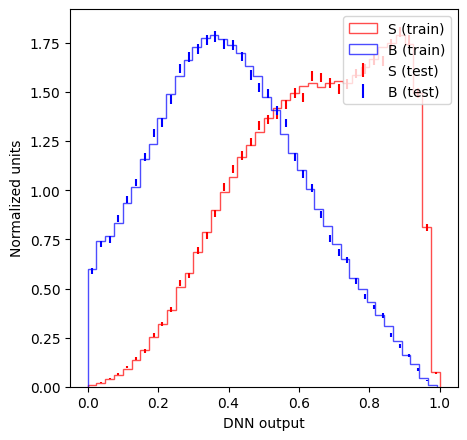

In [84]:

compare_train_test(model_shallow,X_train,y_train,X_test,y_test)

### Exercize: Try to improve this dnn model by including more features,removing dropout, trying different hyper-parameters